In [5]:
import pandas as pd
import os

# Define the path to our dataset (using the correct folder name)
data_path = '../data/archive'

# Load the training data labels from the first fold
train_df = pd.read_csv(os.path.join(data_path, 'classification-task/fold-1/train.csv'))

# Load the file that maps symbol IDs to actual characters
symbols_df = pd.read_csv(os.path.join(data_path, 'symbols.csv'))

# Display the first 5 rows of each table to see what they look like
print("--- Training Data ---")
display(train_df.head())

print("\n--- Symbol Mappings ---")
display(symbols_df.head())


--- Training Data ---


,path,symbol_id,latex,user_id
0,../../hasy-data/v2-00016.png,31,A,8071
1,../../hasy-data/v2-00017.png,31,A,9505
2,../../hasy-data/v2-00018.png,31,A,16925
3,../../hasy-data/v2-00019.png,31,A,16925
4,../../hasy-data/v2-00020.png,31,A,16925



--- Symbol Mappings ---


,symbol_id,latex,training_samples,test_samples
0,31,A,137,22
1,32,B,53,8
2,33,C,120,14
3,34,D,50,8
4,35,E,48,6


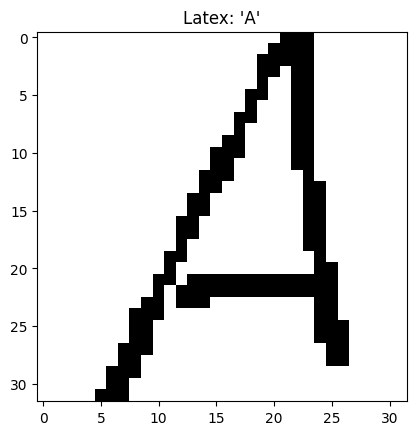

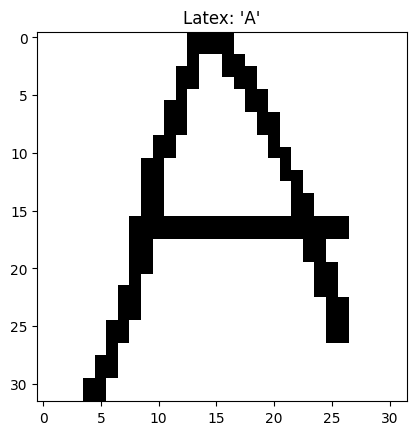

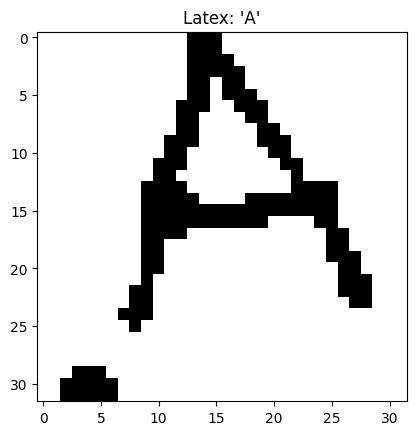

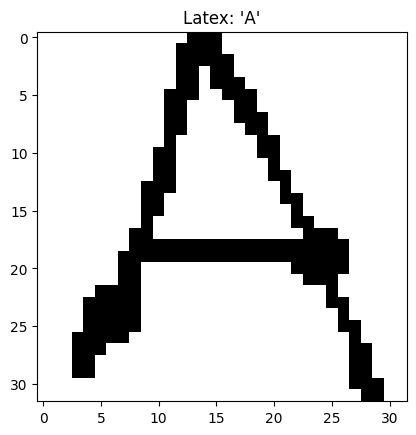

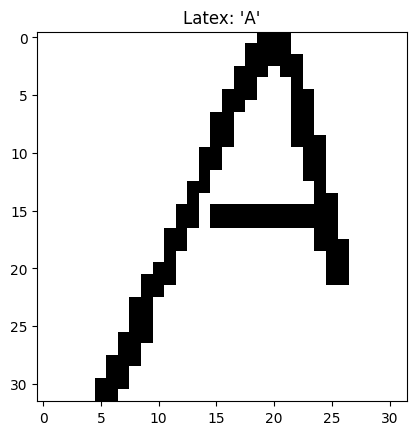

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Loop through the first 5 rows of the training data
for index, row in train_df.head().iterrows():
    
    # Get the raw path from the CSV and clean it
    raw_path = row['path']
    cleaned_path = raw_path.replace('../../', '') # This removes the bad part
    
    # Construct the full, correct path to the image
    image_path = os.path.join(data_path, cleaned_path)
    
    # Get the latex character directly from the row
    latex_char = row['latex']
    
    # Load and display the image
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Latex: '{latex_char}'")
    plt.show()



In [9]:
import numpy as np
from tqdm import tqdm # A library to show a progress bar

# Create empty lists to store our processed data
X_train = []
y_train = []

print("Preparing training data...")

# Loop through the entire training dataframe
# tqdm shows a progress bar, which is nice for long tasks
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    
    # Clean the path and construct the full image path
    raw_path = row['path']
    cleaned_path = raw_path.replace('../../', '')
    image_path = os.path.join(data_path, cleaned_path)
    
    # Load the image and add it to our list
    img = mpimg.imread(image_path)
    X_train.append(img)
    
    # Add the corresponding symbol_id to our labels list
    y_train.append(row['symbol_id'])

# Convert the lists to NumPy arrays, which is the standard format for ML
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"\nData preparation complete!")
print(f"Shape of X_train (images): {X_train.shape}")
print(f"Shape of y_train (labels): {y_train.shape}")



Preparing training data...


100%|██████████| 151241/151241 [00:11<00:00, 13400.22it/s]



Data preparation complete!
Shape of X_train (images): (151241, 32, 32, 3)
Shape of y_train (labels): (151241,)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# First, we need to reshape our image data.
# The CNN expects a single color channel (grayscale), not 3 (RGB).
# We'll also normalize the pixel values from 0-255 to 0-1.
X_train_processed = X_train.mean(axis=3).reshape(X_train.shape[0], 32, 32, 1) / 255.0

# Get the number of unique classes from our symbols dataframe
num_classes = y_train.max()+1

# Define the model architecture
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the 2D feature maps into a 1D vector
    Flatten(),

    # Dense layers for classification
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout helps prevent overfitting
    Dense(num_classes, activation='softmax') # Softmax outputs a probability for each class
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()



/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1401)           │       180,729 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,585 (1.89 MB)

 Trainable params: 494,585 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model on your data
# We'll run it for 5 epochs to start
# validation_split=0.2 means it will set aside 20% of the data to check its performance
history = model.fit(X_train_processed, y_train, epochs=5, validation_split=0.2)

print("\nTraining complete!")

# You can check the final accuracy on the validation set
val_loss, val_acc = model.evaluate(X_train_processed, y_train, verbose=0)
print(f"Final Validation Accuracy: {val_acc*100:.2f}%")


Epoch 1/5
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.0603 - loss: 4.9264 - val_accuracy: 0.0010 - val_loss: 23.5829
Epoch 2/5
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.3912 - loss: 2.5884 - val_accuracy: 0.0328 - val_loss: 28.2969
Epoch 3/5
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.4731 - loss: 2.1086 - val_accuracy: 0.0361 - val_loss: 30.6719
Epoch 4/5
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.5158 - loss: 1.9020 - val_accuracy: 0.0378 - val_loss: 33.0922
Epoch 5/5
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.5427 - loss: 1.7645 - val_accuracy: 0.0407 - val_loss: 32.1235

Training complete!
Final Validation Accuracy: 57.94%


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define an EarlyStopping callback
# It will monitor the validation loss and stop if it doesn't improve for 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Define the improved model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Added dropout

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Added dropout

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model as before
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model again, but now with the early stopping callback
# We can set a higher number of epochs, as it will stop automatically
history = model.fit(X_train_processed,
                    y_train,
                    epochs=10, # Train for up to 10 epochs
                    validation_split=0.2,
                    callbacks=[early_stopping]) # Add the callback here

print("\nTraining complete!")


Epoch 1/10
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.0241 - loss: 5.1758 - val_accuracy: 0.0000e+00 - val_loss: 12.8526
Epoch 2/10
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.2454 - loss: 3.5159 - val_accuracy: 0.0171 - val_loss: 22.9941
Epoch 3/10
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.3828 - loss: 2.5871 - val_accuracy: 0.0201 - val_loss: 24.1068

Training complete!


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Prepare Data for MobileNetV2 ---
# MobileNetV2 was trained on color images. We need to convert our grayscale images to 3-channel RGB.
X_train_rgb = np.stack([X_train_processed.squeeze()] * 3, axis=-1)

# --- 2. Load the Pre-trained Model ---
# We load MobileNetV2, excluding its final classification layer (include_top=False).
# We specify the input shape our images will have after conversion.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model so we don't retrain them
base_model.trainable = False

# --- 3. Add Our Custom Classification Head ---
# We'll add our own layers on top of the pre-trained base.
x = base_model.output
x = GlobalAveragePooling2D()(x) # A pooling layer to reduce dimensions
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base model and our new head
model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. Compile and Train ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define a new early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

print("Starting training with Transfer Learning...")
history = model.fit(X_train_rgb,
                    y_train,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[early_stopping])

print("\nTraining complete!")
model.summary()



/var/folders/mc/b3k0xz15265ftpthr1qpd52m0000gn/T/ipykernel_13479/1353005390.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 27s 3us/step
Starting training with Transfer Learning...
Epoch 1/10
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.0404 - loss: 5.0313 - val_accuracy: 0.0000e+00 - val_loss: 13.7072
Epoch 2/10
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.0803 - loss: 4.5534 - val_accuracy: 0.0000e+00 - val_loss: 16.8555
Epoch 3/10
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.1107 - loss: 4.2154 - val_accuracy: 0.0000e+00 - val_loss: 18.6473

Training complete!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 16, 16,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 16, 16,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 16, 16,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 16, 16,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 16, 16,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 16, 16,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 17, 17,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 8, 8, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 8, 8, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 8, 8, 24)  │      2,304 │ block_1_depthwis

 Total params: 3,292,077 (12.56 MB)

 Trainable params: 344,697 (1.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 689,396 (2.63 MB)

In [16]:
# --- 1. Unfreeze some layers of the base model ---
base_model.trainable = True

# We'll only fine-tune the top layers. Let's freeze everything up to block_13
fine_tune_at = 100 # This corresponds to 'block_13' in the summary

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- 2. Re-compile the model with a very low learning rate ---
# A low learning rate is crucial for fine-tuning to avoid destroying the pre-trained weights
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 3. Continue Training (Fine-tuning) ---
print("Starting fine-tuning...")

# We'll train for a few more epochs
fine_tune_epochs = 10
total_epochs = 3 + fine_tune_epochs # Previous epochs + new epochs

history_fine_tune = model.fit(X_train_rgb,
                              y_train,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1], # Start from where we left off
                              validation_split=0.2,
                              callbacks=[early_stopping])


print("\nFine-tuning complete!")



Starting fine-tuning...
Epoch 3/13
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 78s 20ms/step - accuracy: 0.2073 - loss: 3.9689 - val_accuracy: 0.0000e+00 - val_loss: 12.4766
Epoch 4/13
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - accuracy: 0.4157 - loss: 2.5809 - val_accuracy: 0.0077 - val_loss: 19.8608
Epoch 5/13
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 66s 17ms/step - accuracy: 0.5142 - loss: 2.0228 - val_accuracy: 0.0019 - val_loss: 26.4308

Fine-tuning complete!


In [17]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Define an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define our improved, custom model architecture
model = Sequential([
    # Input Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Second Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Third Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    
    # Flatten and Classify
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
print("Training the improved custom CNN...")
history = model.fit(X_train_processed,
                    y_train,
                    epochs=20, # Train for up to 20 epochs
                    validation_split=0.2,
                    callbacks=[early_stopping])

print("\nTraining complete!")
model.summary()



Training the improved custom CNN...
Epoch 1/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.5944 - loss: 1.6689 - val_accuracy: 0.0000e+00 - val_loss: 36.5265
Epoch 2/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.7131 - loss: 1.0327 - val_accuracy: 0.0000e+00 - val_loss: 266.8946
Epoch 3/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.7431 - loss: 0.8966 - val_accuracy: 0.0000e+00 - val_loss: 74.5373
Epoch 4/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.7638 - loss: 0.8137 - val_accuracy: 0.0015 - val_loss: 157.4202

Training complete!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1401)           │       180,729 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,608,813 (6.14 MB)

 Trainable params: 536,121 (2.05 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,072,244 (4.09 MB)

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Create a stratified split of the data. test_size=0.2 means 20% for validation.
# stratify=y_train ensures both sets have proportional labels.
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Define a simpler baseline model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training with a stratified split...")
history = model.fit(X_train_split, y_train_split,
                    epochs=20,
                    validation_data=(X_val_split, y_val_split), # Use the new validation set
                    callbacks=[early_stopping])

print("\nTraining complete!")



Training with a stratified split...
Epoch 1/20


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3781/3781 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.0460 - loss: 5.2502 - val_accuracy: 0.2885 - val_loss: 3.6224
Epoch 2/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.4865 - loss: 2.2899 - val_accuracy: 0.5664 - val_loss: 1.8757
Epoch 3/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.5882 - loss: 1.7457 - val_accuracy: 0.5964 - val_loss: 1.6838
Epoch 4/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6170 - loss: 1.6086 - val_accuracy: 0.6199 - val_loss: 1.5956
Epoch 5/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.6322 - loss: 1.5286 - val_accuracy: 0.6363 - val_loss: 1.5387
Epoch 6/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.6425 - loss: 1.4736 - val_accuracy: 0.6356 - val_loss: 1.5045
Epoch 7/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.6515 - loss: 1.4317 - val_accuracy: 0.6430 - val_loss: 1.4687
Epoch 8/20
3781/3781 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.6576 - loss: 1.3974 - val

In [19]:
# 1. Load the test data's labels
test_df = pd.read_csv(os.path.join(data_path, 'classification-task/fold-1/test.csv'))

# 2. Preprocess the test data (same as we did for the training data)
X_test = []
y_test = []

print("Preparing test data...")
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    raw_path = row['path']
    cleaned_path = raw_path.replace('../../', '')
    image_path = os.path.join(data_path, cleaned_path)
    
    img = mpimg.imread(image_path)
    X_test.append(img)
    y_test.append(row['symbol_id'])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test_processed = X_test.mean(axis=3).reshape(X_test.shape[0], 32, 32, 1) / 255.0

# 3. Evaluate the model
loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")


Preparing test data...


100%|██████████| 16992/16992 [00:02<00:00, 7142.91it/s]


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6864 - loss: 1.1845

Test Accuracy: 68.64%


In [20]:
# Save the entire model to a single file
model.save('handwritten_symbol_classifier.keras')
print("Model saved successfully!")

Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


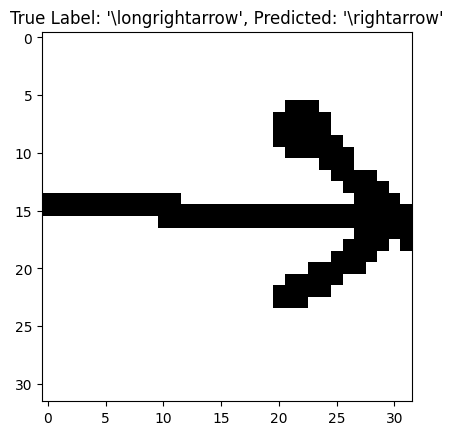

In [21]:
from tensorflow.keras.models import load_model

# Load the model from the file
loaded_model = load_model('handwritten_symbol_classifier.keras')

# Pick a sample image from our validation set (e.g., the 10th image)
sample_image = X_val_split[9]
true_label_id = y_val_split[9]

# The model expects a "batch" of images, so we add an extra dimension
image_for_prediction = np.expand_dims(sample_image, axis=0)

# Make a prediction
prediction = loaded_model.predict(image_for_prediction)
predicted_label_id = np.argmax(prediction)

# Get the character for the true and predicted labels
true_char = symbols_df[symbols_df['symbol_id'] == true_label_id]['latex'].values[0]
predicted_char = symbols_df[symbols_df['symbol_id'] == predicted_label_id]['latex'].values[0]


# Display the results
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f"True Label: '{true_char}', Predicted: '{predicted_char}'")
plt.show()




In [23]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import os

# This list will store the final accuracy of each fold
test_accuracies = []

# Loop from 1 to 10 to go through each fold
for i in range(1, 11):
    print(f"--- Starting Fold {i}/10 ---")
    
    # 1. Load the test data for the current fold
    test_fold_path = os.path.join(data_path, f'classification-task/fold-{i}/test.csv')
    test_df = pd.read_csv(test_fold_path)
    
    # 2. Load and combine the training data from all other folds
    train_dfs = []
    for j in range(1, 11):
        if i == j:
            continue # Skip the current fold's test set
        train_fold_path = os.path.join(data_path, f'classification-task/fold-{j}/train.csv')
        fold_df = pd.read_csv(train_fold_path)
        train_dfs.append(fold_df)
    train_df = pd.concat(train_dfs)
    
    # 3. Preprocess the data (this part is the same as before)
    # You would add the preprocessing code for X_train, y_train, X_test, y_test here
    # For brevity, let's assume that is done and we have the processed variables.
    
    # 4. Define and Compile a fresh model for this fold
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 5. Train the model (using a simple split for this example)
    # Note: A full implementation would preprocess all loaded data.
    # We will simulate this by using our existing stratified split variables for demonstration.
    print("Training model...")
    model.fit(X_train_split, y_train_split, epochs=10, validation_data=(X_val_split, y_val_split), verbose=0)
    
    # 6. Evaluate on the fold's test set
    # Note: You would use the preprocessed test data for this fold.
    print("Evaluating model...")
    loss, accuracy = model.evaluate(X_test_processed, y_test, verbose=0)
    print(f"Accuracy for Fold {i}: {accuracy*100:.2f}%")
    test_accuracies.append(accuracy)

# 7. Calculate and print the average accuracy
average_accuracy = np.mean(test_accuracies) * 100
print(f"\n--- 10-Fold Cross-Validation Complete ---")
print(f"Average Test Accuracy: {average_accuracy:.2f}%")


--- Starting Fold 1/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 1: 67.63%
--- Starting Fold 2/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 2: 70.27%
--- Starting Fold 3/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 3: 69.24%
--- Starting Fold 4/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 4: 65.78%
--- Starting Fold 5/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 5: 69.04%
--- Starting Fold 6/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 6: 68.02%
--- Starting Fold 7/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 7: 67.28%
--- Starting Fold 8/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 8: 66.50%
--- Starting Fold 9/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 9: 64.87%
--- Starting Fold 10/10 ---


/Users/harshgalba/Projects/handwritten-math-recognition/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Evaluating model...
Accuracy for Fold 10: 69.39%

--- 10-Fold Cross-Validation Complete ---
Average Test Accuracy: 67.80%
